# Titanic 
Goal  
It is your job to predict if a passenger survived the sinking of the Titanic or not.
For each in the test set, you must predict a 0 or 1 value for the variable.

Metric  
Your score is the percentage of passengers you correctly predict. This is known as [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier
from fastai.structured import *
from fastai.imports import *

/home/cho/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/cho/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
pd.set_option('display.max_columns', 1000, 'display.max_rows', 1000)

In [4]:
PATH = '/home/cho/fastai/courses/ml1/kaggle/titanic/data'

In [5]:
def split_vals(a,n):
    return a[:n].copy(), a[n:].copy()

In [6]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [7]:
def print_score(m):
    res=[rmse(m.predict(X_train),y_train), rmse(m.predict(X_valid),y_valid),
        m.score(X_train,y_train), m.score(X_valid,y_valid)]
    if hasattr(m,'oob_score_'):
        res.append(m.oob_score_)
        print(res)

In [8]:
df_raw = pd.read_csv(f'{PATH}/train.csv')

In [9]:
df_test_raw = pd.read_csv(f'{PATH}/test.csv')

In [10]:
train_cats(df_raw)

In [11]:
apply_cats(df=df_test_raw, trn=df_raw)

In [12]:
df_trn, y_trn, nas=proc_df(df_raw, 'Survived')

Let's try with setting 20% of my training data set as my validation set

In [13]:
#We allocate 20% of the training set sample as validation set
n_valid = int(len(df_raw)*0.2)
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

### Baseline model

In [14]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.254000254000381, 0.3821876708246056, 0.9354838709677419, 0.8539325842696629, 0.814866760168303]


### First submission to Kaggle

In [135]:
X_test, _, nas = proc_df(df_test_raw, y_fld=None)

In [137]:
X_test.drop(columns='Fare_na', inplace=True)

In [138]:
X_test = X_test.to_numpy()

In [139]:
preds = m.predict(X_test)

In [146]:
output = pd.DataFrame({'PassengerId':df_test_raw['PassengerId'], 'Survived':preds})
output.to_csv('my_submission_v1.csv', index=False)

### Let's look at how much more improvement we get by adding more trees

In [68]:
X_valid.shape

(178, 12)

In [69]:
preds = np.array([t.predict(X_valid) for t in m.estimators_])

In [70]:
preds_stack = np.stack([t.predict(X_valid) for t in m.estimators_])

In [71]:
preds.shape

(40, 178)

In [72]:
preds[:,0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [73]:
np.mean(preds[:,0], axis=0)

0.075

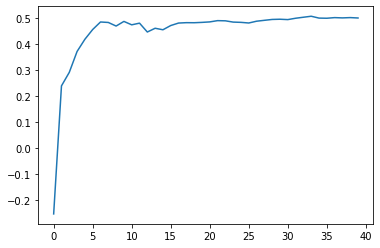

In [78]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

### Feature Importance

In [15]:
fi = rf_feat_importance(m, df_trn)

In [16]:
fi

,cols,imp
3,Sex,0.332425
7,Ticket,0.111942
2,Name,0.101798
8,Fare,0.099255
0,PassengerId,0.092932
4,Age,0.084353
1,Pclass,0.070201
9,Cabin,0.055981
5,SibSp,0.022345
10,Embarked,0.015884


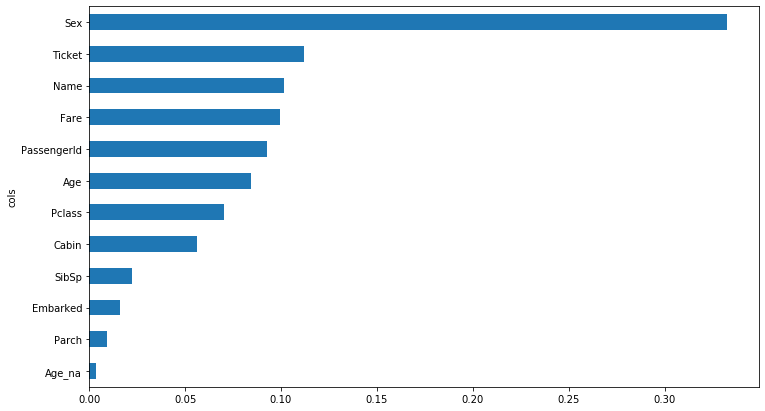

In [18]:
fi.sort_values(by='imp').plot(x='cols', y='imp', kind='barh', figsize=(12,7), legend=False)

In [18]:
filt = fi['imp'] > 0.05
to_keep = fi.loc[filt, 'cols']

In [20]:
df_keep = df_trn[to_keep].copy()

In [22]:
X_train, X_valid = split_vals(df_keep, n_trn)

In [23]:
m = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=3, oob_score=True, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.23979888721877016, 0.3894680901671239, 0.9424964936886395, 0.848314606741573, 0.8246844319775596]


In [28]:
feats = df_trn.columns

In [30]:
for f in feats:
    df_subs = df_trn.drop(columns=f)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print('if removed', f)
    print_score(m)

if removed PassengerId
[0.2567462824977951, 0.36719403681726276, 0.9340813464235624, 0.8651685393258427, 0.8274894810659187]
if removed Pclass
[0.24841714905356074, 0.39661488976905146, 0.938288920056101, 0.8426966292134831, 0.8120617110799438]
if removed Name
[0.2567462824977951, 0.3515615246553262, 0.9340813464235624, 0.8764044943820225, 0.8092566619915849]
if removed Sex
[0.2700579128582149, 0.47993445245333805, 0.9270687237026648, 0.7696629213483146, 0.6942496493688639]
if removed Age
[0.280252340711105, 0.4173215826802953, 0.9214586255259467, 0.8258426966292135, 0.8134642356241234]
if removed SibSp
[0.251224211588132, 0.3594627701808178, 0.9368863955119214, 0.8707865168539326, 0.8246844319775596]
if removed Parch
[0.23979888721877016, 0.3594627701808178, 0.9424964936886395, 0.8707865168539326, 0.8162692847124825]
if removed Ticket
[0.2700579128582149, 0.4173215826802953, 0.9270687237026648, 0.8258426966292135, 0.8274894810659187]
if removed Fare
[0.254000254000381, 0.3671940368172

In [43]:
df_raw['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

It seems that if we removed embarked, the model will perform worse. "Embarked" is the port of embarkation.

### Remove redundant features

In [14]:
import scipy.cluster.hierarchy as sch
from scipy import stats

In [22]:
corr = np.round(stats.spearmanr(df_trn).correlation, 4)

In [23]:
corr_condensed = sch.distance.squareform(1-corr)

In [24]:
z = sch.linkage(corr_condensed, method='average')

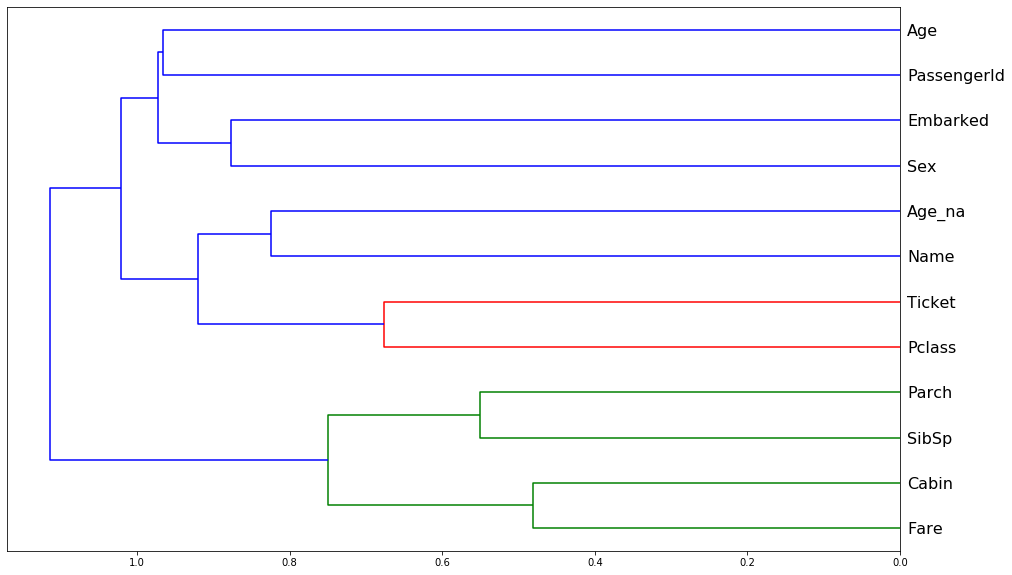

In [25]:
fig = plt.figure(figsize=(16,10))
dendrogram = sch.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16) #Create a distance matrix
plt.show()

In [39]:
def get_oob(df):
    m=RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [44]:
cols_to_remove=['PassengerId','Embarked','Age_na','Pclass','SibSp','Fare','Name','Cabin']

In [45]:
[print(c, get_oob(df_trn.drop(columns=c))) for c in cols_to_remove]

PassengerId 0.8316970546984572
Embarked 0.814866760168303
Age_na 0.8176718092566619
Pclass 0.8120617110799438
SibSp 0.8050490883590463
Fare 0.8064516129032258
Name 0.8120617110799438
Cabin 0.8162692847124825


[None, None, None, None, None, None, None, None]

### Dropping these columns seem to improve the validation score slightly.

In [14]:
to_drop = ['Name','Cabin','PassengerId','Age_na']

In [15]:
df_keep = df_trn.drop(columns=to_drop)

In [86]:
X_train, X_valid = split_vals(df_keep, n_trn)

In [87]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2924961490258477, 0.3515615246553262, 0.9144460028050491, 0.8764044943820225, 0.8246844319775596]


### Second submission to Kaggle

We are processing the test set with proc_df() but we do not need have a y value to split so we use _ and y_fld=None

In [122]:
X_test, _, nas = proc_df(df_test_raw, y_fld=None)

There is a missing value in the Fare column and proc_df() generates a Fare_na column, but this was not in the training set.

In [123]:
X_test.drop(columns='Fare_na', inplace=True)

Based on above checks, dropping below columns improved the validation score

In [124]:
to_drop = ['Name','Cabin','PassengerId','Age_na']

In [125]:
X_test.drop(columns=to_drop, inplace=True)

In [126]:
X_test = X_test.to_numpy()

In [127]:
preds = m.predict(X_test)

In [136]:
output = pd.DataFrame({'PassengerId':df_test_raw['PassengerId'], 'Survived':preds})
output.to_csv('/home/cho/fastai/courses/ml1/kaggle/my_submission_v2.csv', index=False)

### How can we improve the score?

#### One hot encoding

In [25]:
df_trn2, y_trn, nas=proc_df(df_raw,'Survived', max_n_cat=7)

In [26]:
df_trn2.sample(3)

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_na,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
795,796,2,622,39.0,0,0,224,13.0000,0,False,0,1,0,0,0,1,0
91,92,3,32,20.0,0,0,342,7.8542,0,False,0,1,0,0,0,1,0
662,663,1,172,47.0,0,0,497,25.5875,133,False,0,1,0,0,0,1,0


In [57]:
X_train, X_valid = split_vals(df_trn2, n_trn)

The validation score did not seem to improve from baseline.

In [58]:
m = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2427056465258688, 0.3594627701808178, 0.94109396914446, 0.8707865168539326, 0.820476858345021]


In [59]:
fi = rf_feat_importance(m, df_trn2)

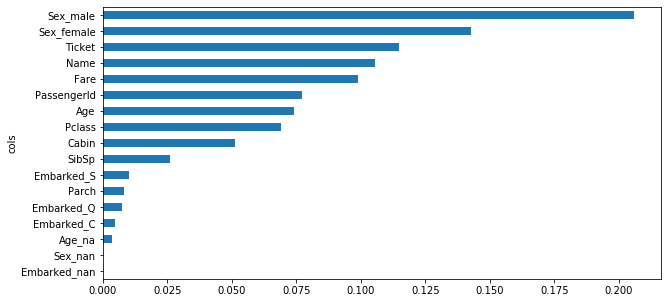

In [84]:
fi.sort_values(by='imp').plot(kind='barh', x='cols', y='imp', legend=False, figsize=(10,5))

Let's look at some probabilities of men vs women survival  
How is the test set different from training/validation set?

In [81]:
raw_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
106,107,1,3,"Salkjelsvik, Miss. Anna Kristine",female,21.0,0,0,343120,7.6500,NaN,S
618,619,1,2,"Becker, Miss. Marion Louise",female,4.0,2,1,230136,39.0000,F4,S
451,452,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,S


In [94]:
df_test_raw.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
177,1069,1,NaN,male,54.0,1,0,NaN,55.4417,NaN,C
301,1193,2,NaN,male,NaN,0,0,NaN,15.0458,D,C
162,1054,2,NaN,female,26.0,0,0,NaN,13.5000,NaN,S


In [66]:
raw_train['Sex'].value_counts(normalize=True)

male      0.640954
female    0.359046
Name: Sex, dtype: float64

In [67]:
df_test_raw['Sex'].value_counts(normalize=True)

male      0.636364
female    0.363636
Name: Sex, dtype: float64

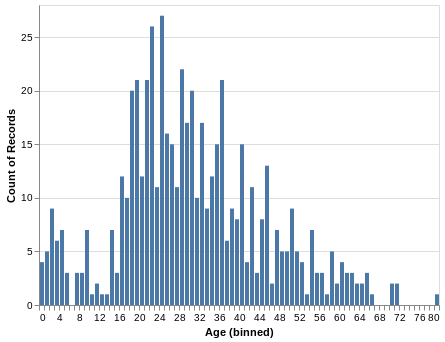

In [80]:
alt.Chart(raw_train).mark_bar().encode(
    x=alt.X('Age',bin=alt.Bin(maxbins=80)),
    y='count():Q'
)

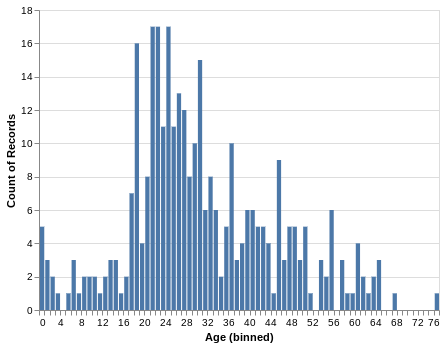

In [79]:
alt.Chart(df_test_raw).mark_bar().encode(
    x=alt.X('Age', bin=alt.Bin(maxbins=80)),
    y='count():Q'
)

In [96]:
raw_train['Pclass'].value_counts(normalize=True)

3    0.546985
1    0.246844
2    0.206171
Name: Pclass, dtype: float64

In [97]:
df_test_raw['Pclass'].value_counts(normalize=True)

3    0.521531
1    0.255981
2    0.222488
Name: Pclass, dtype: float64

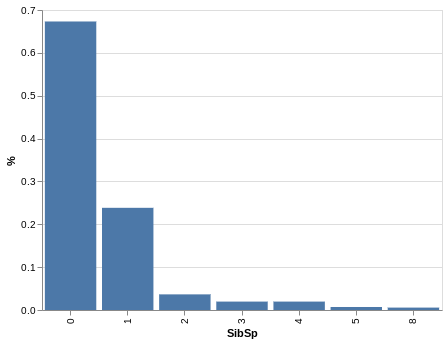

In [37]:
raw_agg = raw_train['SibSp'].value_counts(normalize=True).reset_index()

alt.Chart(raw_agg).mark_bar().encode(
    x=alt.X('index:O', title='SibSp'),
    y=alt.Y('SibSp:Q', title='%'),
    tooltip=['index','SibSp']
)

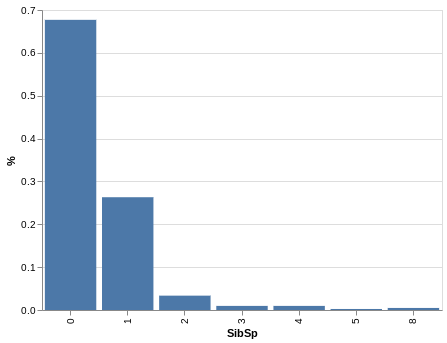

In [34]:
test_agg = df_test_raw['SibSp'].value_counts(normalize=True).reset_index()

alt.Chart(test_agg).mark_bar().encode(
    x=alt.X('index:O', title='SibSp'),
    y=alt.Y('SibSp:Q', title='%'),
    tooltip=['index','SibSp']
)

In [37]:
raw_train['Survived'].value_counts(normalize=True)

0    0.608696
1    0.391304
Name: Survived, dtype: float64

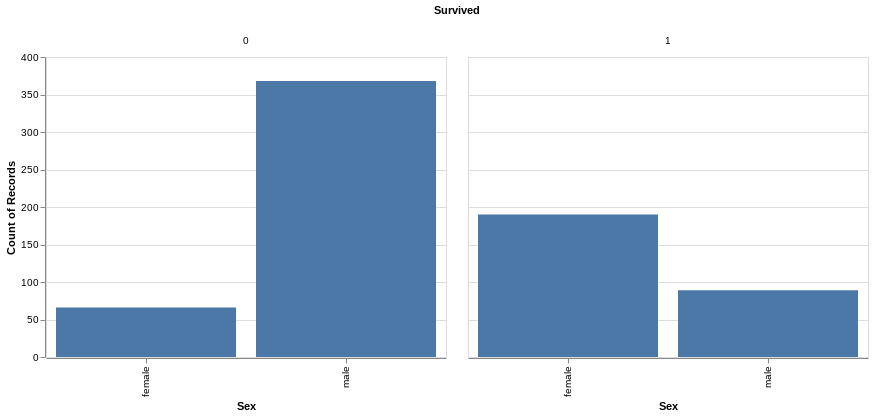

In [78]:
alt.Chart(raw_train).mark_bar().encode(
    column='Survived',
    x='Sex',
    y='count():Q',
    tooltip=['count(Sex)']
)

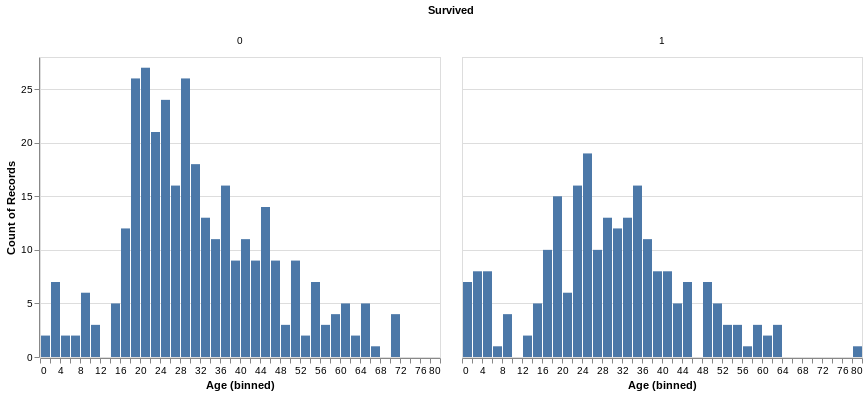

In [47]:
alt.Chart(raw_train).mark_bar().encode(
    column='Survived',
    x=alt.X('Age',bin=alt.Bin(maxbins=50)),
    y='count():Q'
)

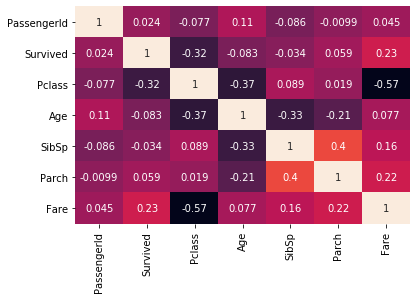

In [28]:
sns.heatmap(raw_train.corr(), annot=True, cbar=False)

In [32]:
raw_train.corr()['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.233524
Parch          0.058619
PassengerId    0.023652
SibSp         -0.033852
Age           -0.083113
Pclass        -0.317694
Name: Survived, dtype: float64

We encode the sex categorical variable to 1 for female and 0 for male and examine the correlation with survived

In [48]:
sex_map = {'male':0,'female':1}
raw_train['sex_encoded'] = raw_train['Sex'].map(sex_map).astype('int64')

A positive correlation of 0.5 means females are more likely to survive

In [52]:
raw_train.corr()['Survived'].sort_values()

Pclass        -0.317694
Age           -0.083113
SibSp         -0.033852
PassengerId    0.023652
Parch          0.058619
Fare           0.233524
sex_encoded    0.538105
Survived       1.000000
Name: Survived, dtype: float64

We can see that of those who survived, 68% are females.

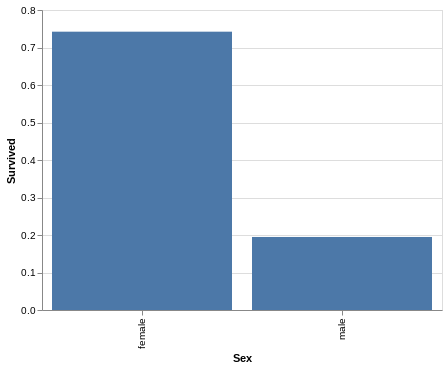

In [128]:
raw_agg = raw_train.groupby(['Sex']).agg({'Survived':'mean'}).reset_index()

alt.Chart(raw_agg).mark_bar().encode(
    x='Sex:N',
    y='Survived:Q',
    tooltip=['Survived','Sex']
)

Pclass 1 has the highest likelihood of surviving 61%

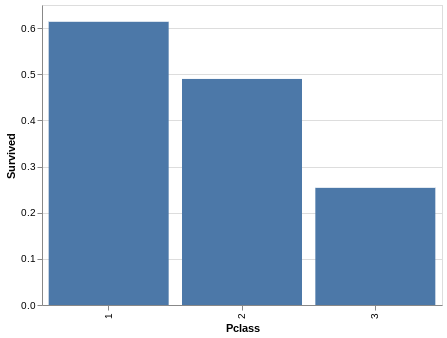

In [127]:
raw_agg = raw_train.groupby(['Pclass']).agg({'Survived':'mean'}).reset_index()

alt.Chart(raw_agg).mark_bar().encode(
    x='Pclass:N',
    y='Survived:Q',
    tooltip=['Survived','Pclass']
)

In [62]:
raw_train['Embarked'].value_counts(normalize=True)

S    0.716292
C    0.193820
Q    0.089888
Name: Embarked, dtype: float64

Those who embarked from Cherbourg has the highest chance of survival, 54%

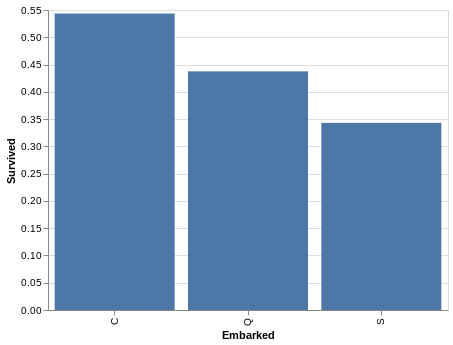

In [119]:
raw_agg = raw_train.groupby(['Embarked']).agg({'Survived':'mean'}).reset_index()

alt.Chart(raw_agg).mark_bar().encode(
    x='Embarked:N',
    y='Survived:Q',
    tooltip=['Survived','Embarked']
)

In [14]:
raw_train.groupby(['Embarked','Pclass']).agg({'Survived':'sum'})

Survived
Embarked Pclass          
C        1             50
         2              6
         3             19
Q        1              1
         2              2
         3             25
S        1             56
         2             64
         3             55

It seems we could create some combined columns to see the feature importance

In [42]:
pd.crosstab(index=raw_train['Embarked'], columns=raw_train.query('Survived == 1')['Pclass'], normalize='index')

Pclass,1,2,3
Embarked,,,
C,0.666667,0.080000,0.253333
Q,0.035714,0.071429,0.892857
S,0.320000,0.365714,0.314286


Embarked S = 3, Q = 2, C = 1

#### Create combined Pclass and Embarked binary variables 

In [100]:
df_raw2 = df_raw.copy()

In [101]:
df_raw2['title'] = df_raw2['Name'].str.extract('([A-za-z]+)\.')

In [102]:
df_trn2, y_trn, nas = proc_df(df_raw2, 'Survived')

In [103]:
df_trn2['p1ec'] = np.where((df_trn2['Embarked'] == 1) & (df_trn2['Pclass'] == 1), 1, 0)
df_trn2['p2ec'] = np.where((df_trn2['Embarked'] == 1) & (df_trn2['Pclass'] == 2), 1, 0)
df_trn2['p3ec'] = np.where((df_trn2['Embarked'] == 1) & (df_trn2['Pclass'] == 3), 1, 0)
df_trn2['p1eq'] = np.where((df_trn2['Embarked'] == 2) & (df_trn2['Pclass'] == 1), 1, 0)
df_trn2['p2eq'] = np.where((df_trn2['Embarked'] == 2) & (df_trn2['Pclass'] == 2), 1, 0)
df_trn2['p3eq'] = np.where((df_trn2['Embarked'] == 2) & (df_trn2['Pclass'] == 3), 1, 0)
df_trn2['p1es'] = np.where((df_trn2['Embarked'] == 3) & (df_trn2['Pclass'] == 1), 1, 0)
df_trn2['p2es'] = np.where((df_trn2['Embarked'] == 3) & (df_trn2['Pclass'] == 2), 1, 0)
df_trn2['p3es'] = np.where((df_trn2['Embarked'] == 3) & (df_trn2['Pclass'] == 3), 1, 0)
df_trn2['male'] = np.where(df_trn2['Sex'] == 2, 1, 0)
df_trn2['female'] = np.where(df_trn2['Sex'] == 1, 1, 0)

In [104]:
df_trn2.drop(columns='Sex', inplace=True)

In [105]:
X_train, X_valid = split_vals(df_trn2, n_trn)

In [106]:
df_trn2.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,Age_na,p1ec,p2ec,p3ec,p1eq,p2eq,p3eq,p1es,p2es,p3es,male,female
0,1,3,109,22.0,1,0,524,7.2500,0,3,13,False,0,0,0,0,0,0,0,0,1,1,0
1,2,1,191,38.0,1,0,597,71.2833,82,1,14,False,1,0,0,0,0,0,0,0,0,0,1
2,3,3,354,26.0,0,0,670,7.9250,0,3,10,False,0,0,0,0,0,0,0,0,1,0,1
3,4,1,273,35.0,1,0,50,53.1000,56,3,14,False,0,0,0,0,0,0,1,0,0,0,1
4,5,3,16,35.0,0,0,473,8.0500,0,3,13,False,0,0,0,0,0,0,0,0,1,1,0


In [107]:
X_train.head(3)

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,Age_na,p1ec,p2ec,p3ec,p1eq,p2eq,p3eq,p1es,p2es,p3es,male,female
0,1,3,109,22.0,1,0,524,7.2500,0,3,13,False,0,0,0,0,0,0,0,0,1,1,0
1,2,1,191,38.0,1,0,597,71.2833,82,1,14,False,1,0,0,0,0,0,0,0,0,0,1
2,3,3,354,26.0,0,0,670,7.9250,0,3,10,False,0,0,0,0,0,0,0,0,1,0,1


In [79]:
df_raw.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
521,522,0,3,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
648,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S


In [113]:
pd.crosstab(index=df_raw2['title'], columns=df_raw2['Sex'])

Sex,female,male
title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [108]:
m = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2567462824977951, 0.3894680901671239, 0.9340813464235624, 0.848314606741573, 0.82328190743338]


In [109]:
fi = rf_feat_importance(m, df_trn2)

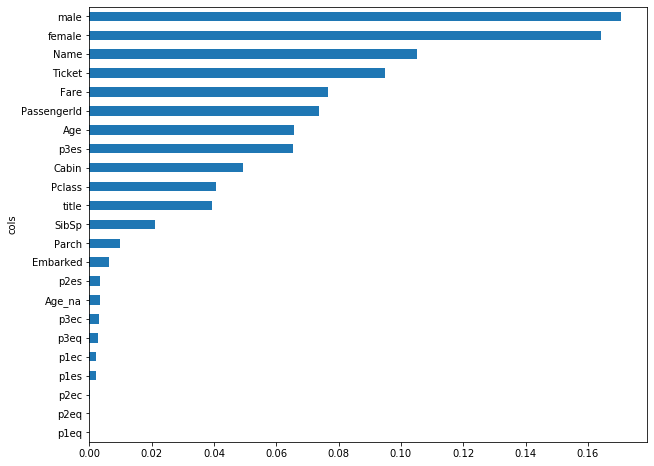

In [110]:
fi.sort_values(by='imp').plot(kind='barh', x='cols', y='imp', figsize=(10,8), legend=False)

#### Adjusting the parameters of Random Forest

Let's start use 100 trees instead of 40.
min_samples_leaf, the higher it is, the less deep the tree grows, and less likely to overfit.

In [74]:
to_drop = ['Name','Cabin','PassengerId', 'Age_na']

In [75]:
df_keep = df_trn.drop(columns=to_drop)

In [76]:
X_train, X_valid = split_vals(df_keep, n_trn)

In [77]:
m = RandomForestClassifier(n_estimators=100, max_features=0.5, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.29725249584033764, 0.34347857005916343, 0.9116409537166901, 0.8820224719101124, 0.8288920056100981]


In the training dataset, we have a survival rate of 39%


In [78]:
fi = rf_feat_importance(m, df_keep)

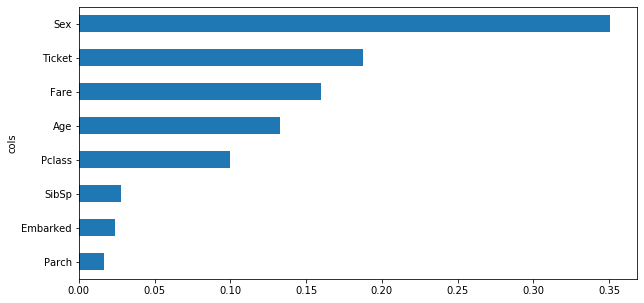

In [79]:
fi.sort_values(by='imp').plot(kind='barh', x='cols', y='imp', figsize=(10,5), legend=False)

### Third submission to Kaggle

In [120]:
X_test, _, nas = proc_df(df_test_raw, y_fld=None)

There is a missing value in the Fare column and proc_df() generates a Fare_na column, but this was not in the training set.

In [121]:
X_test.drop(columns='Fare_na', inplace=True)

Based on above checks, dropping below columns improved the validation score

In [122]:
to_drop = ['Name','Cabin','PassengerId','Age_na']

In [123]:
X_test.drop(columns=to_drop, inplace=True)

In [126]:
X_test = X_test.to_numpy()

In [128]:
preds = m.predict(X_test)

In [133]:
output = pd.DataFrame({'PassengerID':df_test_raw['PassengerId'], 'Survived':preds})
output.to_csv('/home/cho/fastai/courses/ml1/kaggle/my_submission_v3.csv', index=False)

#### Create a family size feature

In [22]:
df_raw2 = df_raw.copy()

In [23]:
df_raw2['title'] = df_raw2['Name'].str.extract('([A-za-z]+)\.')

In [24]:
df_raw2['FamilySize'] = df_raw2['Parch'] + df_raw2['SibSp'] + 1

In [33]:
df_trn, y_trn, nas=proc_df(df_raw2, 'Survived')

In [34]:
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [36]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.24841714905356074, 0.3821876708246056, 0.938288920056101, 0.8539325842696629, 0.8274894810659187]


In [37]:
fi = rf_feat_importance(m, df_trn)

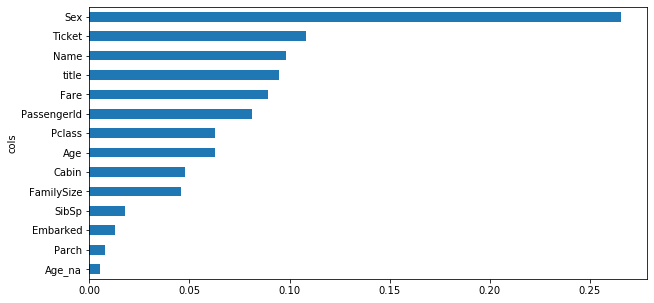

In [38]:
fi.sort_values(by='imp').plot(kind='barh', x='cols', y='imp', figsize=(10,5), legend=False)

In [39]:
import scipy.cluster.hierarchy as sch
from scipy import stats

In [49]:
corr = np.round(stats.spearmanr(df_trn).correlation, 4)

In [54]:
corr_condensed = sch.distance.squareform(1-corr)

In [57]:
z = sch.linkage(corr_condensed, method='average')

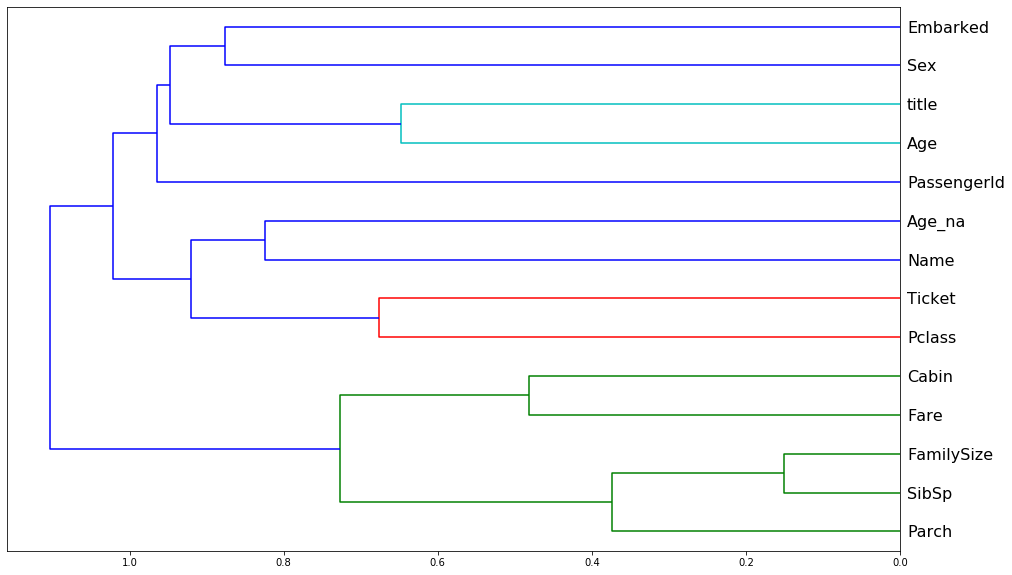

In [58]:
fig = plt.figure(figsize=(16,10))
dendrogram = sch.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16) #Create a distance matrix
plt.show()

In [83]:
df_raw = pd.read_csv(f'{PATH}/train.csv')

In [13]:
df_raw2 = df_raw.copy()

In [14]:
df_raw2['title'] = df_raw2['Name'].str.extract('([A-za-z]+)\.')

In [15]:
df_raw2['FamilySize'] = df_raw2['Parch'] + df_raw2['SibSp'] + 1

In [18]:
train_cats(df_raw2)

In [19]:
df_raw2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
 12  title        891 non-null    category
 13  FamilySize   891 non-null    int64   
dtypes: category(6), float64(2), int64(6)
memory usage: 143.0 KB


In [36]:
df_trn, y_trn, nas=proc_df(df_raw2, 'Survived', max_n_cat=5)

In [37]:
to_drop = ['Name', 'Cabin', 'PassengerId', 'Age_na']
df_trn.drop(columns=to_drop, inplace=True)

In [38]:
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [39]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.29008873237471905, 0.34347857005916343, 0.9158485273492286, 0.8820224719101124, 0.8288920056100981]


In [40]:
fi = rf_feat_importance(m, df_trn)

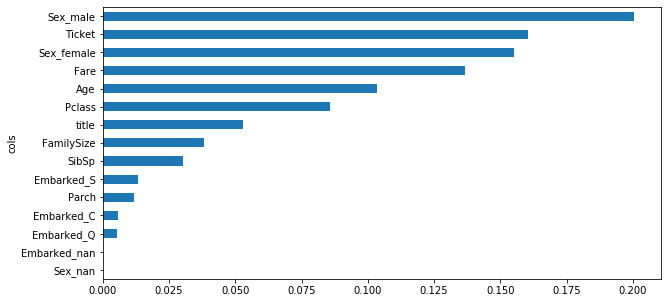

In [41]:
fi.sort_values(by='imp').plot(kind='barh', x='cols', y='imp', figsize=(10,5), legend=False)